In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import collections
import random
import string
import re
import torch.nn.functional as F
from sklearn.manifold import TSNE
from matplotlib import pylab
import matplotlib.pyplot as plt

from matplotlib.font_manager import FontProperties

In [6]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [7]:
root = '/content/hindi.txt'

In [8]:
%matplotlib inline
hindi_font = FontProperties(fname=os.path.join(root, 'Nirmala.ttf'))

In [9]:
def clean_text(sentence, language):
    """
        Input: String, String
        Output: String
        Takes in text as string. Returns text cleaned for NMT purposes.
    """
    if language == None:
        print("Please enter which language.")
        return None

    exclude = set(string.punctuation)
    remove_digits = str.maketrans('', '', string.digits)

    if language == 'en':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence

    elif language == 'hi':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)

        sent_temp = ''
        for c in sentence:
            if c == ' ':
                sent_temp += c
            elif ord(u'\u0900') <= ord(c) <= ord(u'\u097F'):
                sent_temp += c
        sentence = sent_temp

        sentence = re.sub('[a-z]', '', sentence)
        sentence = re.sub('[०१२३४५६७८९।]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence

    elif language == 'ma':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = re.sub('[a-z]', '', sentence)
        sentence = re.sub('[०१२३४५६७८९।]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence

    else:
        print("Language not found")
        return None

In [11]:
def read_data(filename):
    data = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            data.extend(clean_text(line.strip(), 'hi').split(' '))
    return data

# Specify the filename to read from
filename = '/content/hindi.txt'
words = read_data(filename)
print("Data size %d" % len(words))

Data size 55998


In [12]:
vocabulary_size = int(len(set(words)) // 1.2)
print(vocabulary_size)

6935


In [13]:
def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()

    for word, _ in count:
        dictionary[word] = len(dictionary)

    data = list()
    unk_count = 0

    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)

    count[0][1] = unk_count

    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print("Vocabulary size", vocabulary_size)
print("Most common words (+UNK)", count[:5])
print("Sample data", data[:10])
del words

Vocabulary size 6935
Most common words (+UNK) [['UNK', 1388], ('के', 2734), ('में', 1840), ('है', 1519), ('की', 1322)]
Sample data [2041, 472, 2, 1183, 1184, 132, 182, 1, 1028, 2042]


In [14]:
data_index = 0

def generate_batch(batch_size, bag_window):
    global data_index
    span = 2 * bag_window + 1
    batch = np.ndarray(shape=(batch_size, span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size,), dtype=np.int32)  # Change shape to 1D
    context_words = np.ndarray(shape=(batch_size, span-1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)

    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    for i in range(batch_size):
        buffer_list = list(buffer)
        labels[i] = buffer_list.pop(bag_window)
        batch[i] = buffer_list
        context_words[i] = buffer_list

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels, context_words


print('Data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
    data_index = 0
    batch, labels, context_words = generate_batch(batch_size=4, bag_window=bag_window)
    print("\nwith bag_window = %d:" % (bag_window))
    print(" batch:", [[reverse_dictionary[w] for w in bi] for bi in batch])
    print(" label:", [reverse_dictionary[li] for li in labels.reshape(4)])
    print(" context_words:", [[reverse_dictionary[w] for w in ci] for ci in context_words])  # Print context_words as well


Data: ['आपकी', 'कार', 'में', 'ब्लैक', 'बॉक्स', 'जबकि', 'अमेरिका', 'के', 'सड़क', 'योजनाकार', 'ध्वस्त', 'होते', 'हुए', 'हाईवे', 'सिस्टम', 'को']

with bag_window = 1:
 batch: [['आपकी', 'में'], ['कार', 'ब्लैक'], ['में', 'बॉक्स'], ['ब्लैक', 'जबकि']]
 label: ['कार', 'में', 'ब्लैक', 'बॉक्स']
 context_words: [['आपकी', 'में'], ['कार', 'ब्लैक'], ['में', 'बॉक्स'], ['ब्लैक', 'जबकि']]

with bag_window = 2:
 batch: [['आपकी', 'कार', 'ब्लैक', 'बॉक्स'], ['कार', 'में', 'बॉक्स', 'जबकि'], ['में', 'ब्लैक', 'जबकि', 'अमेरिका'], ['ब्लैक', 'बॉक्स', 'अमेरिका', 'के']]
 label: ['में', 'ब्लैक', 'बॉक्स', 'जबकि']
 context_words: [['आपकी', 'कार', 'ब्लैक', 'बॉक्स'], ['कार', 'में', 'बॉक्स', 'जबकि'], ['में', 'ब्लैक', 'जबकि', 'अमेरिका'], ['ब्लैक', 'बॉक्स', 'अमेरिका', 'के']]


In [15]:
batch_size = 128
embedding_size = 128
bag_window = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

class SkipGramModel(nn.Module):
    def __init__(self, vocabulary_size, embedding_size):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocabulary_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocabulary_size)

    def forward(self, target, context):
        embeds = self.embeddings(context)
        scores = self.linear(embeds.sum(dim=1))
        return scores

model = SkipGramModel(vocabulary_size, embedding_size)
optimizer = optim.Adagrad(model.parameters(), lr=1.0)
print(model)

SkipGramModel(
  (embeddings): Embedding(6935, 128)
  (linear): Linear(in_features=128, out_features=6935, bias=True)
)


In [ ]:
num_steps = 100001
save_interval = 2000

for step in range(num_steps):
    batch_data, batch_labels, _ = generate_batch(batch_size, bag_window)
    batch_data = torch.tensor(batch_data, dtype=torch.long)
    batch_labels = torch.tensor(batch_labels, dtype=torch.long).view(-1, 1)

    optimizer.zero_grad()
    scores = model(batch_labels, batch_data)
    loss = F.cross_entropy(scores, batch_labels.view(-1))
    loss.backward()
    optimizer.step()

    if step % 2000 == 0:
        print("Average loss at step %d: %f" % (step, loss.item()))

        # Save the model
        if step % save_interval == 0:
            torch.save(model.state_dict(), f'model_checkpoint_{step}.pth')

    if step % 10000 == 0:
        with torch.no_grad():
            valid_embeddings = model.embeddings(torch.tensor(valid_examples, dtype=torch.long))
            similarity = torch.mm(valid_embeddings, model.embeddings.weight.t())
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-similarity[i, :]).argsort()[1:top_k + 1]
                log = "Nearest to %s:" % valid_word

                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k].item()]
                    log = "%s %s" % (log, close_word)
                print(log)

# Save the final model
torch.save(model.state_dict(), 'final_model.pth')
final_embeddings = model.embeddings.weight.data.numpy()

Average loss at step 0: 9.600649
Nearest to हुई: ऑफसेट उठाने निकाला देना वजह घुसने वोकल्स स्वीडेन
Nearest to एक: प्रभावित विकार श्रमिकों पुराने धन एंथनी विवादास्पद राजपूत
Nearest to है: मुद्दा मनोचिकित्सक दूरी हरियाणा आज़माइश निश्चितः इच्छा अक्षम
Nearest to इन: आ मॉडल्स मारिजुआना लापरवाही डैशबोर्ड उस ग्रीस पादशाही
Nearest to वे: टोपी बल एयरप्लेन लिंक कॉलचेस्टर बर्मिंघम फिरौती चिह्नांकित
Nearest to द्वारा: स्थान एनएसटीएमए हुए बजाए अनुग्रह प्रत्येक पाकिस्तान पैतृक
Nearest to जो: कितने लोग तहत वहीं हिम्मत झटका चुकी पाकुड़
Nearest to किया: कमी रहस्य नेजर्मनी पंच बिजली वैल्यूमैक्स अतिथि बैरोनेस
Nearest to और: शर्तें जैसा अशोक रहस्यों पहुँच रिग पेट्रोलियम यूटॉ
Nearest to दौरान: सूचना हैक कारपोरेट किताबें आबिद लूट हुड्डा वैन
Nearest to उन्हें: गोल्फ हुए रहे सीनेट लंबितजायेंगे रिकॉर्डकीपर सस्ती विधेयक
Nearest to पर: डैशबोर्ड नेटवर्क बनाने होते बजट चुनाव क्षमता एलोआ
Nearest to करना: विशेषाधिकार सफ़ाई कार्यालय पर पहरा संभालकर चादवीर तहत
Nearest to थी: व्यापारिक प्रिमियम छूट संसदीय पिछड़े मुद्दा 

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

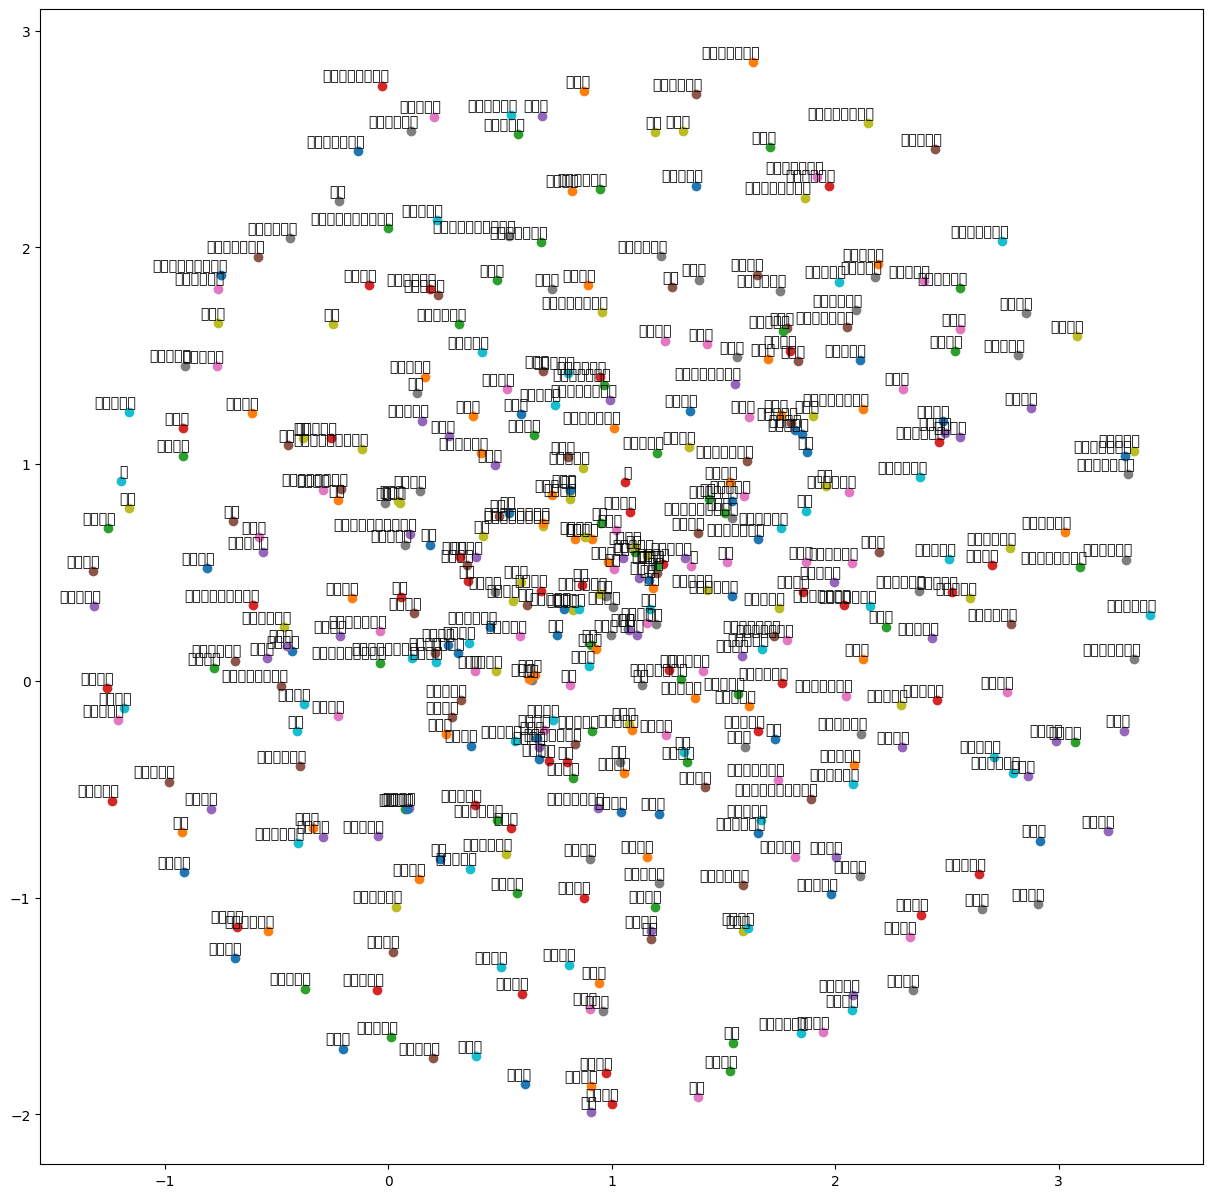

In [ ]:
# Visualization using t-SNE
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points + 1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15, 15))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)

In [ ]:
# Load the pre-trained model
model = SkipGramModel(vocabulary_size, embedding_size)
model.load_state_dict(torch.load('/content/final_model.pth'))
model.eval()

# Load the Nirmala.ttf font
hindi_font_path = '/content/Nirmala.ttf'
hindi_font = FontProperties(fname=hindi_font_path)

# Visualization using t-SNE
num_points = 400

with torch.no_grad():
    final_embeddings = model.embeddings.weight.data.numpy()
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points + 1, :])

def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15, 15))

    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontproperties=hindi_font)

    plt.show()

words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)